In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib as plt
%matplotlib inline
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
SparkSession available as 'spark'.


In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql import DataFrameReader
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import *

In [3]:
spark = SparkSession \
    .builder \
    .appName('pyspark_demo_app') \
    .config('spark.driver.extraClassPath',
            'postgresql-42.2.9') \
    .master("local[*]") \
    .getOrCreate()

In [4]:
# tips on jdbc ... https://sparkour.urizone.net/recipes/using-jdbc/#03
# Load properties from file
import json
with open("../data-load/Resources/db-properties.json") as propertyFile:
    properties = json.load(propertyFile)

dbMode = "overwrite"
jdbc_url= properties["jdbcUrl"]
dbConfig = {"user": properties["user"], 
          "password": properties["password"], 
          "driver": properties["driver"]
         }

In [5]:
entireDF = spark.read.jdbc(url=jdbc_url, table = 'heart_cardio_train', properties=dbConfig)
entireDF.printSchema()
entireDF.limit(5).show()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)

+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
| id|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+---+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  0|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|  1|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|  2|18857|     1|   165|  64.0|  130|   70|          3|   1| 

In [6]:
#convert to pandas df
heart_cardio = entireDF.select("*").toPandas()
heart_cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
heart_cardio=heart_cardio.drop(columns='id', axis=1)
heart_cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Data-preprocessing

In [7]:
heart_cardio.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

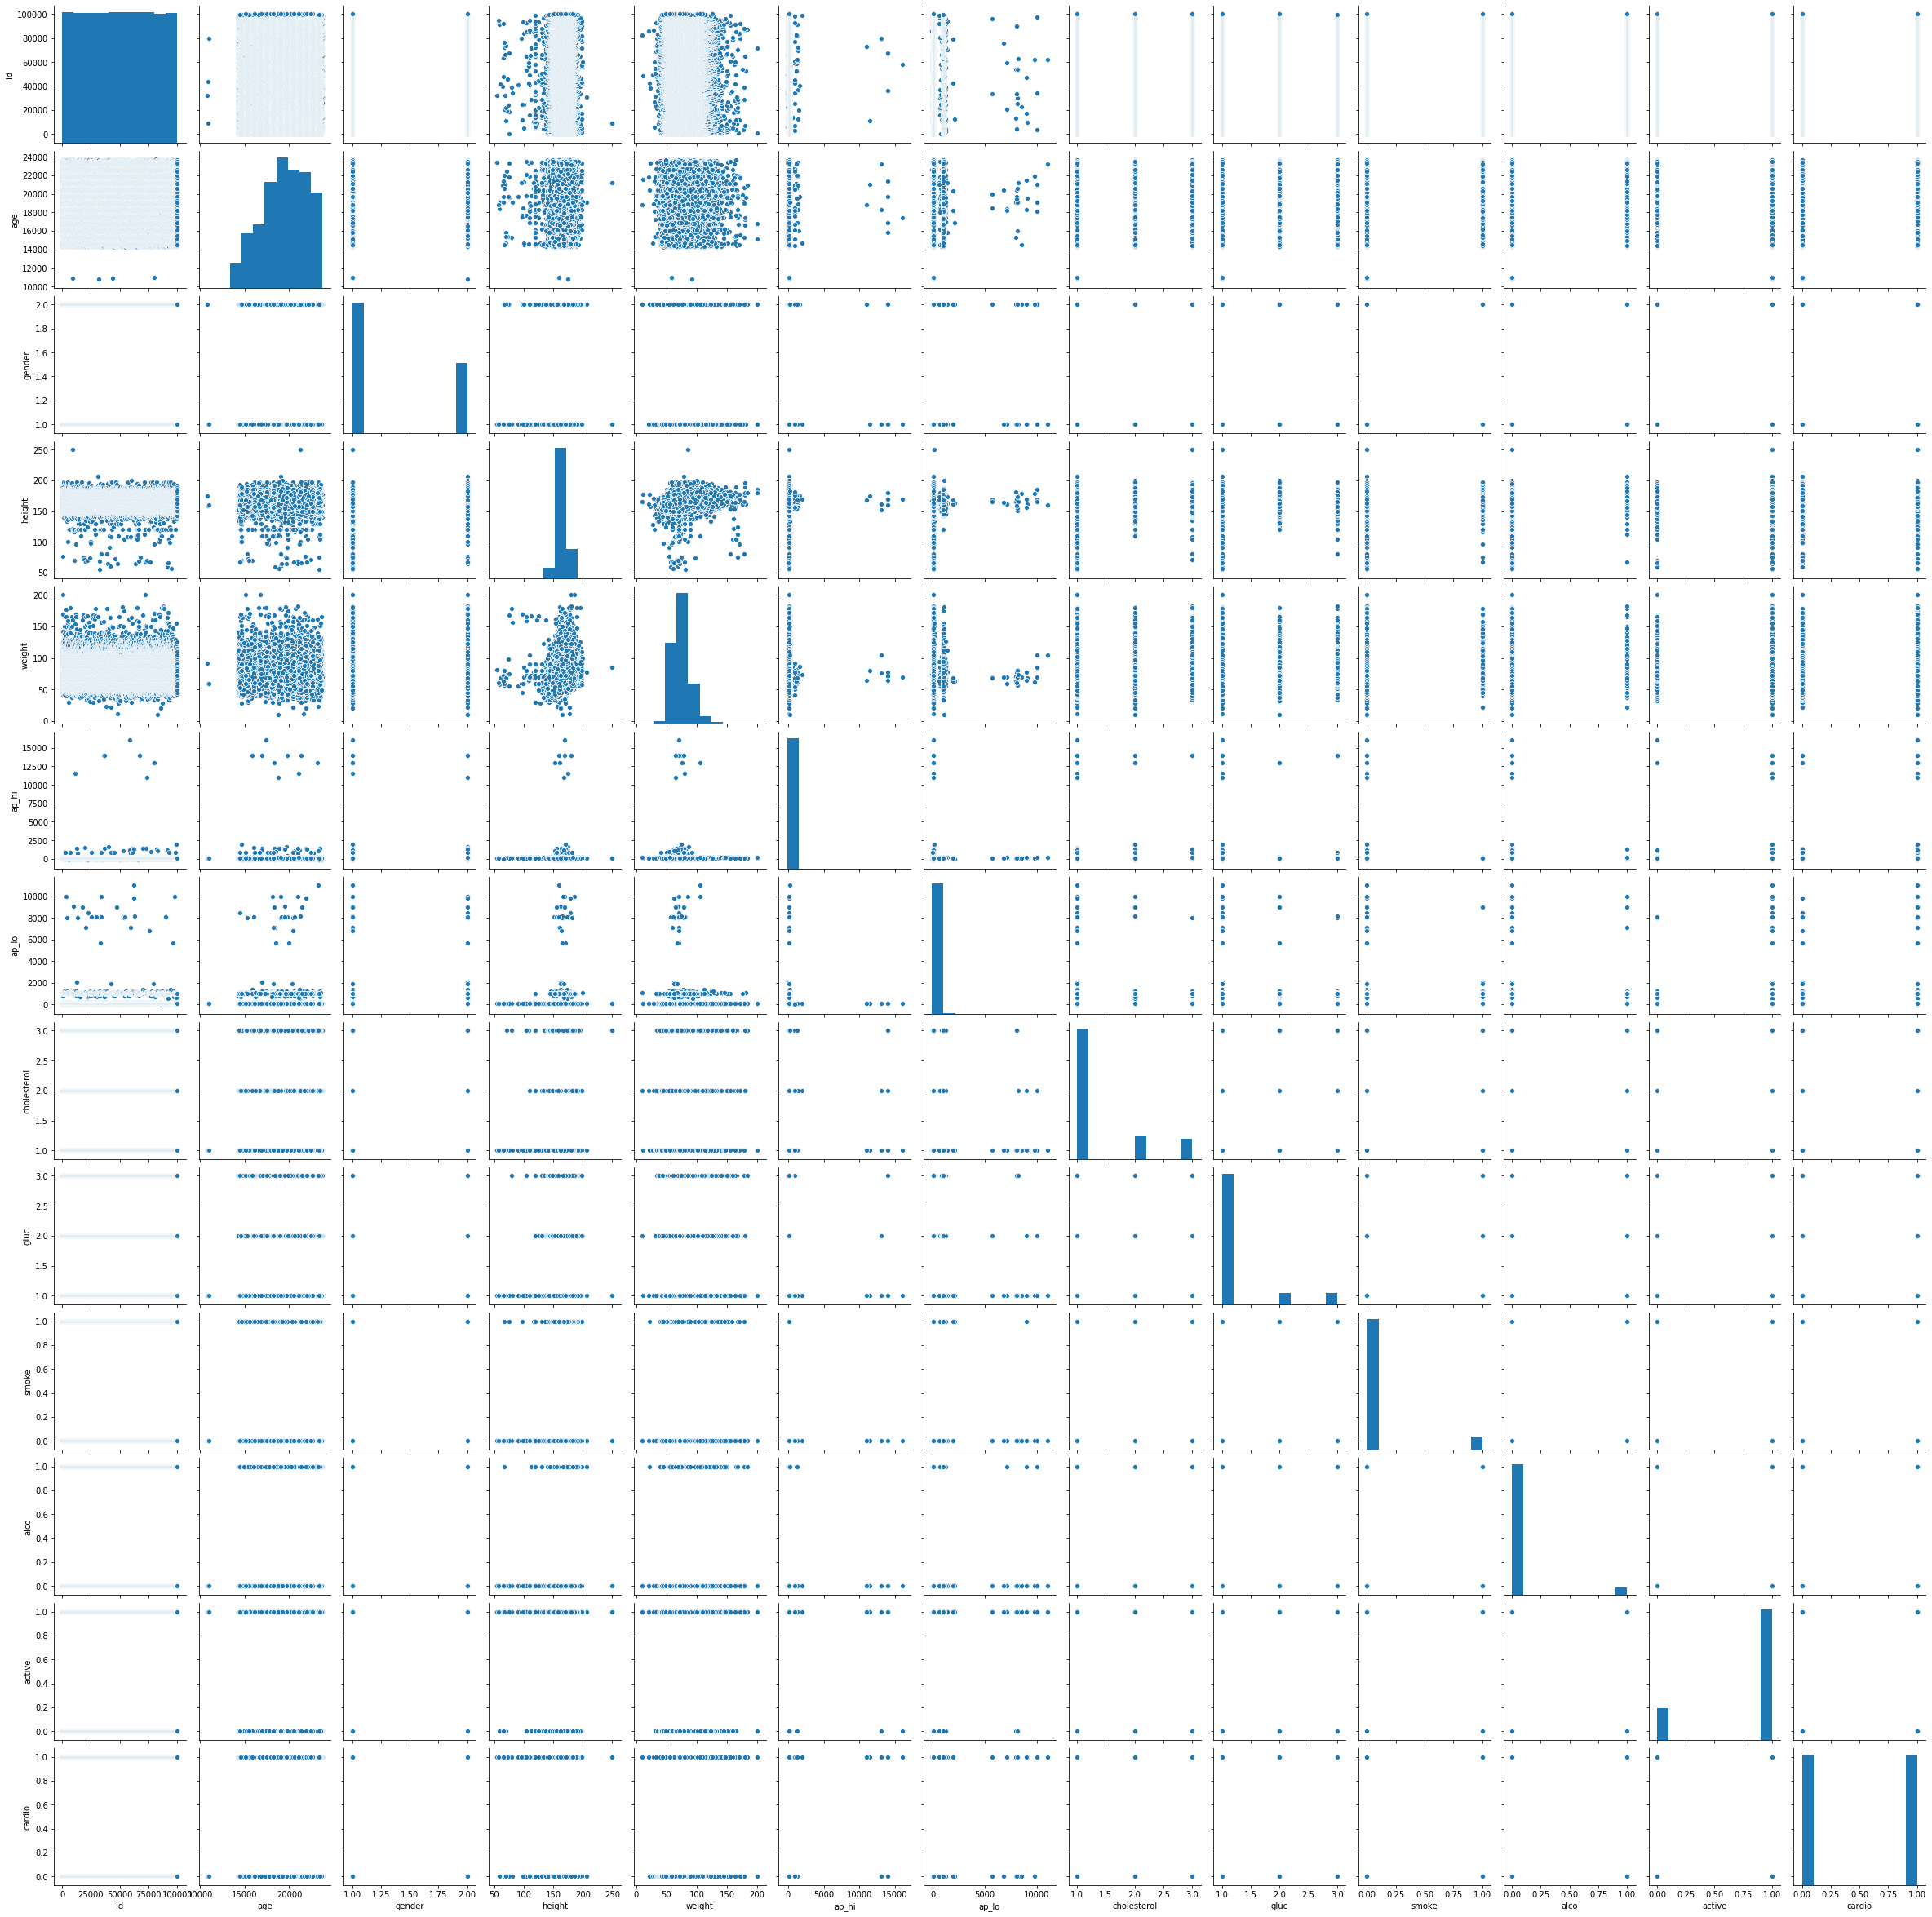

In [8]:
# import seaborn as sns
sns.pairplot(data=heart_cardio)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125ee1f50>,
      dtype=object)

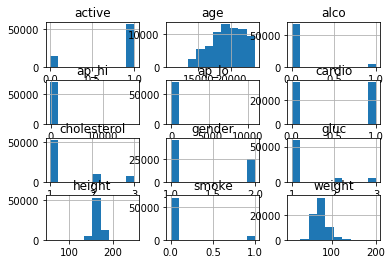

In [11]:
heart_cardio.hist()

In [36]:
target = heart_cardio["cardio"]
data = heart_cardio.drop("cardio", axis=1)
feature_names = data.columns
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168,62.0,110,80,1,1,0,0,1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0


In [17]:
#Check distribution of datapoints in categorical lab


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train.info()
X_test.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 273 to 102
Data columns (total 15 columns):
age         237 non-null float64
sex         237 non-null float64
trestbps    237 non-null float64
chol        237 non-null float64
fbs         237 non-null float64
restecg     237 non-null float64
thalach     237 non-null float64
exang       237 non-null float64
oldpeak     237 non-null float64
slope       237 non-null float64
ca          237 non-null float64
thal        237 non-null float64
cp_2.0      237 non-null uint8
cp_3.0      237 non-null uint8
cp_4.0      237 non-null uint8
dtypes: float64(12), uint8(3)
memory usage: 24.8 KB


age         60
sex         60
trestbps    60
chol        60
fbs         60
restecg     60
thalach     60
exang       60
oldpeak     60
slope       60
ca          60
thal        60
cp_2.0      60
cp_3.0      60
cp_4.0      60
dtype: int64

In [86]:
# from sklearn.preprocessing import StandardScaler as ss
# sc = ss()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

# Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
from keras.models import Sequential
from keras.layers import Dense
import warnings

Using TensorFlow backend.
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

# Label encoding, create dummy variables

In [29]:
data_encoded = data.copy()
data_binary_encoded=pd.get_dummies(data_encoded, columns=['cp','slope', 'thal','restecg'])
# data_binary_encoded=pd.get_dummies(data_encoded)
data_binary_encoded.head()

KeyError: "['cp'] not in index"

In [14]:
chest_pain=pd.get_dummies(heart_ml_df['cp'],prefix='cp',drop_first=True)
heart_ml_df=pd.concat([heart_ml_df,chest_pain],axis=1)
heart_ml_df.drop(['cp'],axis=1,inplace=True)
sp=pd.get_dummies(heart_ml_df['slope'],prefix='slope')
th=pd.get_dummies(heart_ml_df['thal'],prefix='thal')
rest_ecg=pd.get_dummies(heart_ml_df['restecg'],prefix='restecg')
frames=[heart_ml_df,sp,th,rest_ecg]
heart_ml_df=pd.concat(frames,axis=1)
heart_ml_df.drop(['slope','thal','restecg'],axis=1,inplace=True)

KeyError: 'cp'